<a href="https://colab.research.google.com/github/Luke-Mason/DeepLearningA1/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

AUTOTUNE = tf.data.experimental.AUTOTUNE
import tensorflow_datasets as tfds
import pathlib
import shutil
import tempfile
from  IPython import display
import math
from sklearn import preprocessing
import tensorflow.keras as keras
from scipy.ndimage.interpolation import rotate, shift
from tensorflow.keras import layers
from shutil import copy2
!pip install tensorflow-addons
import tensorflow_addons as tfa

import struct
from keras.layers.merge import add, concatenate
import argparse
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from scipy.interpolate import interp1d
import random
import cv2
import matplotlib.patches as patches
from google.colab import drive

     |████████████████████████████████| 1.1 MB 2.7 MB/s 


# Mount Drive

In [2]:
# Mount the google drive to get the imagery data and get any saved models previously.
drive.mount('/content/drive', force_remount=True)

# Change according to your directory structure
!cp /content/drive/'My Drive'/DL/Distance_dataset.zip .
!unzip -q -o Distance_dataset.zip
!rm Distance_dataset.zip
!ls

# Load the csv data, which contains references to the imagery data.
data = pd.read_csv('./data_updated.csv', delimiter=',')

Mounted at /content/drive
Images/08_OUTSIDE_0969.png  bad CRC d020a927  (should be 4836895b)
data_updated.csv  drive  Images  __MACOSX  README.md  sample_data


# EDA
Data exploration to lead to a well informed approach.

In [3]:
data.head()

,file_path,distance,scene,personID,xmax,xmin,ymax,ymin
0,Images/07_OUTSIDE_1198.png,14.9,OUTSIDE,7,323.16498,313.81473,201.65112,170.32014
1,Images/01_OUTSIDE_3420.png,6.7,OUTSIDE,1,333.87970,297.28207,249.00247,165.39919
2,Images/11_OUTSIDE_5506.png,7.3,OUTSIDE,11,169.90585,145.17395,231.83516,165.30717
3,Images/06_OUTSIDE_3869.png,7.9,OUTSIDE,6,369.01447,349.55515,234.96034,174.08122
4,Images/06_OUTSIDE_3952.png,7.5,OUTSIDE,6,317.37772,293.60165,240.42155,172.18889


In [8]:
data.describe()

,distance,personID,xmax,xmin,ymax,ymin
count,12434.000000,12434.000000,12434.000000,12434.000000,12434.000000,12434.000000
mean,9.572044,6.836818,343.027532,312.328405,239.087899,168.900679
std,4.520799,3.671217,89.077768,82.763834,50.052365,15.919413
min,1.000000,1.000000,146.863110,0.000000,139.239030,16.027660
25%,5.800000,4.000000,315.212230,275.121013,203.070780,165.088630
50%,9.300000,6.000000,337.259535,316.322025,219.942710,169.598395
75%,13.400000,10.000000,409.422465,380.769350,256.881728,173.132953
max,19.500000,15.000000,672.000000,600.093000,376.000000,313.083800


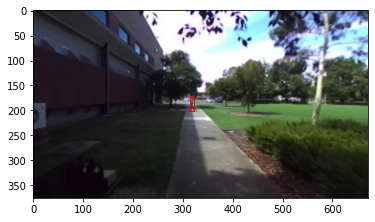

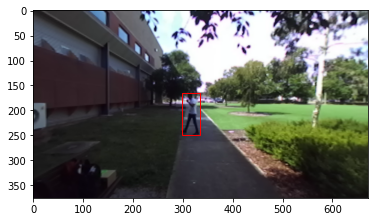

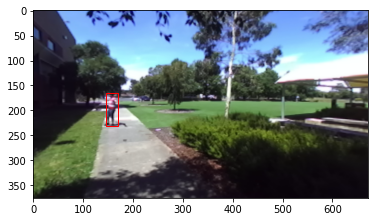

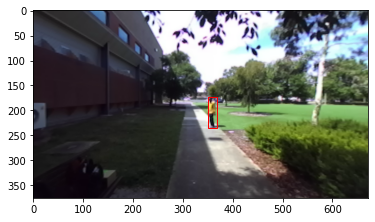

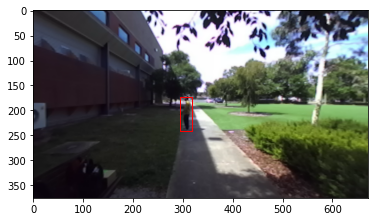

In [4]:
samples = 5

for index, row in data.iterrows():
  if index >= samples:
    continue

  img = np.asarray(Image.open('./' + row["file_path"]))
  xmax = row["xmax"]
  ymax = row["ymax"]
  xmin = row["xmin"]
  ymin = row["ymin"]

  # Create a Rectangle patch
  rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')

  # Create figure and axes
  fig, ax = plt.subplots()

  # Add the patch to the Axes
  ax.add_patch(rect)

  # Display the image
  ax.imshow(img)

In [33]:
largest_height = 0
largest_width = 0
most_bands = 0

img_list = list(data["file_path"])

# Check image sizes
for image in img_list:
  img = Image.open('./' + image)
  img_numpy = np.ascontiguousarray(img, dtype=np.float32)
  print(img_numpy.shape)
  if largest_height < img_numpy.shape[0]:
    largest_height = img_numpy.shape[0]
  if largest_width < img_numpy.shape[1]:
    largest_width = img_numpy.shape[1]
  if most_bands < img_numpy.shape[2]:
      most_bands = img_numpy.shape[2]
print("largest dimensions for all images: \nH:{} W:{} C:{}".format(largest_height, largest_width, most_bands))

(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 672, 4)
(376, 

TypeError: ignored

403.0
183.0
240.0
306.0
442.0
301.0
0.0
0.0
0.0
203.0
272.0
0.0
314.0
170.0
667.0
361.0
540.0
1253.0
1008.0
843.0
670.0
511.0
985.0
491.0
1298.0
973.0
0.0
0.0


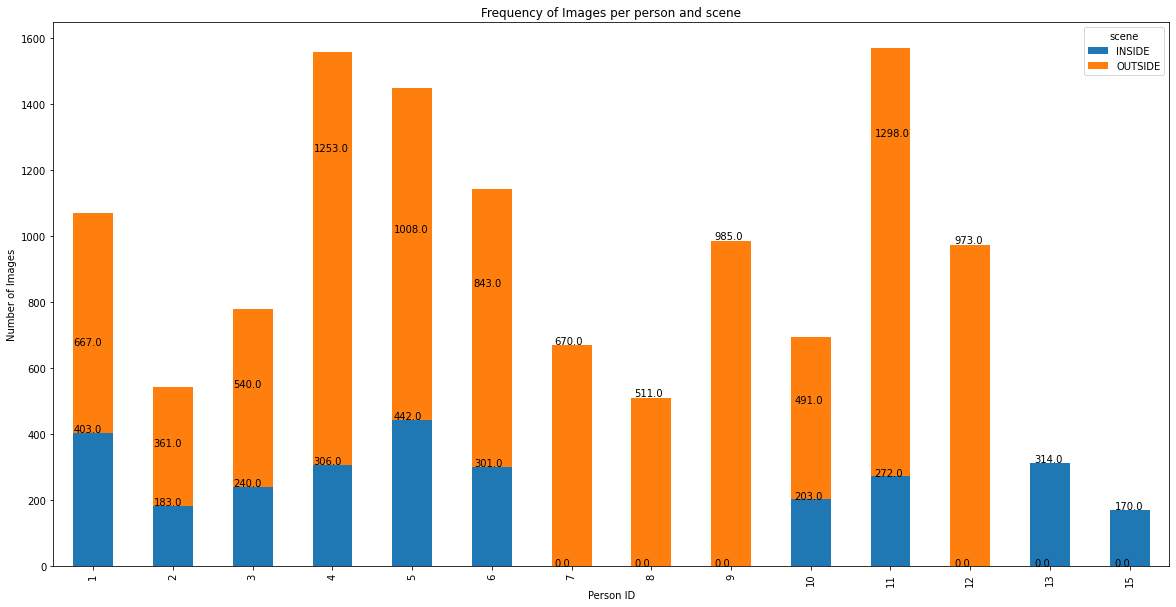

In [20]:
ax = pd.crosstab(data['personID'], data['scene'], margins=False).plot.bar(stacked=True, 
                                                                    figsize=[20,10],
                                                                    title='Frequency of Images per person and scene',
                                                                    xlabel='Person ID',
                                                                    ylabel='Number of Images')

for p in ax.patches:
    print(str(p.get_height()))
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

9600
2834


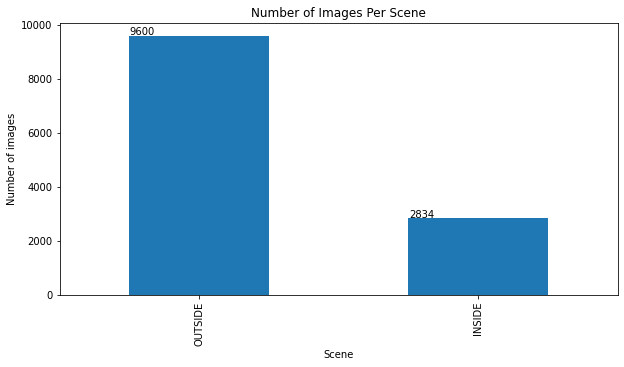

In [21]:
ax = data.scene.value_counts().to_frame().plot(kind='bar',
                                          title='Number of Images Per Scene',
                                          xlabel='Scene', ylabel='Number of images',
                                          legend=False,
                                          figsize=[10,5])

for p in ax.patches:
    print(str(p.get_height()))
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Literature Review

- SSD architecture
- R-CNN
- Fast-R-CNN
- Faster-R-CNN
- YOLOv3



## SSD Architecture
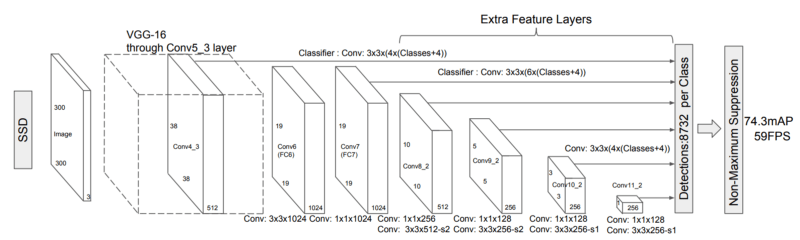

## YOLO v3 Architecture
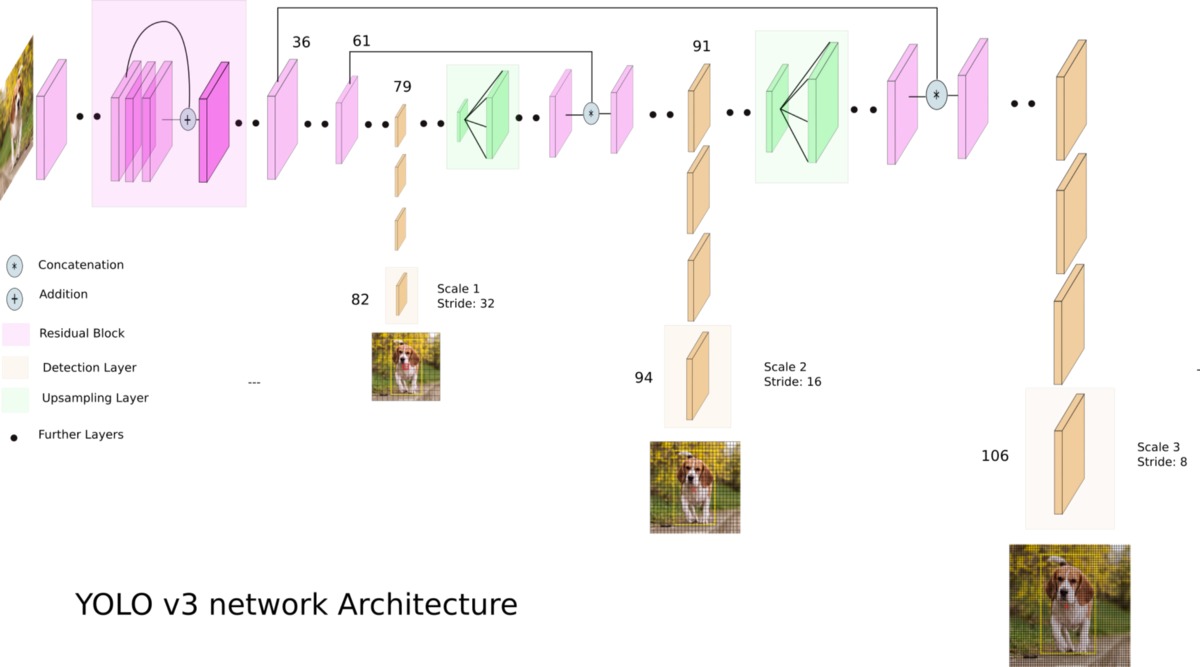

# Evaluation Framework
Mean Average Precision
mAP@0.5 and mAP@0.25




[Ref](https://www.datacamp.com/community/tutorials/object-detection-guide)



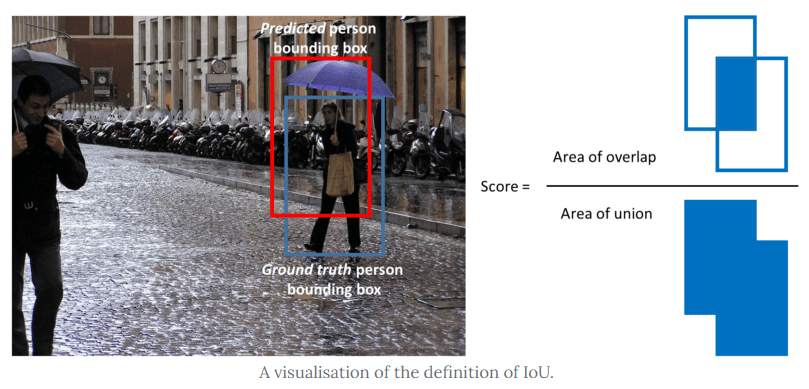

# Split Data

In [5]:
# Split the data
train_set, _x = train_test_split(data, train_size=0.8, shuffle=True, random_state=32)
val_set, test_set = train_test_split(_x, train_size=0.5, shuffle=True, random_state=32)

# Data Generators

In [36]:
def get_imagery_data_sets(train_set, validation_set, test_set, directory, x_col, y_col, batch_size, target_size, aug_params=None):
    """
    Gets the imagery data from the reference id's in each data set.
    :param train_set: The dataframe containing the set of ids in the training set.
    :param validation_set: The dataframe containing the set of validation ids.
    :param test_set: The dataframe containing the test ids.
    :param directory: The directory that the images are located.
    :param y_col: The target column name to make the taget column into a string type.
    :param batch_size: The batch size to which the data generator batches the imagery data.
    :param aug_params: the parameters for the data generator for the training set to help augment the data.
    :return: Returns the 3 data generators (train, validation, test) that have the images data.
    """

    # Transform the pixel values between 0 and 1, by dividing their values by 1/255
    train_datagen = ImageDataGenerator(rescale=1. / 255, data_format='channels_last') if aug_params == None else ImageDataGenerator(rescale=1. / 255, data_format='channels_last', **aug_params)
    val_datagen = ImageDataGenerator(rescale=1. / 255, data_format='channels_last')
    test_datagen = ImageDataGenerator(rescale=1. / 255, data_format='channels_last')

    # The parameters that all data set generators have in common.
    generator_parameters = dict(
        directory=directory,
        x_col=x_col,
        y_col=y_col,
        target_size=target_size,
        color_mode="rgba",
        class_mode='multi_output',
        shuffle=False)

    # Train set generator to evaluate produce dataframe with train images.
    train_imagery_set = train_datagen.flow_from_dataframe(
        dataframe=train_set,
        batch_size=batch_size,
        **generator_parameters)

    # Validation set generator to evaluate produce dataframe with validation images.
    val_imagery_set = val_datagen.flow_from_dataframe(
        dataframe=validation_set,
        batch_size=batch_size,
        **generator_parameters)

    # Test set generator to evaluate produce dataframe with test images.
    test_imagery_set = test_datagen.flow_from_dataframe(
        dataframe=test_set,
        batch_size=1,
        **generator_parameters)

    return train_imagery_set, val_imagery_set, test_imagery_set

## Test Generator is working

Found 9947 validated image filenames.
Found 1243 validated image filenames.
Found 1244 validated image filenames.


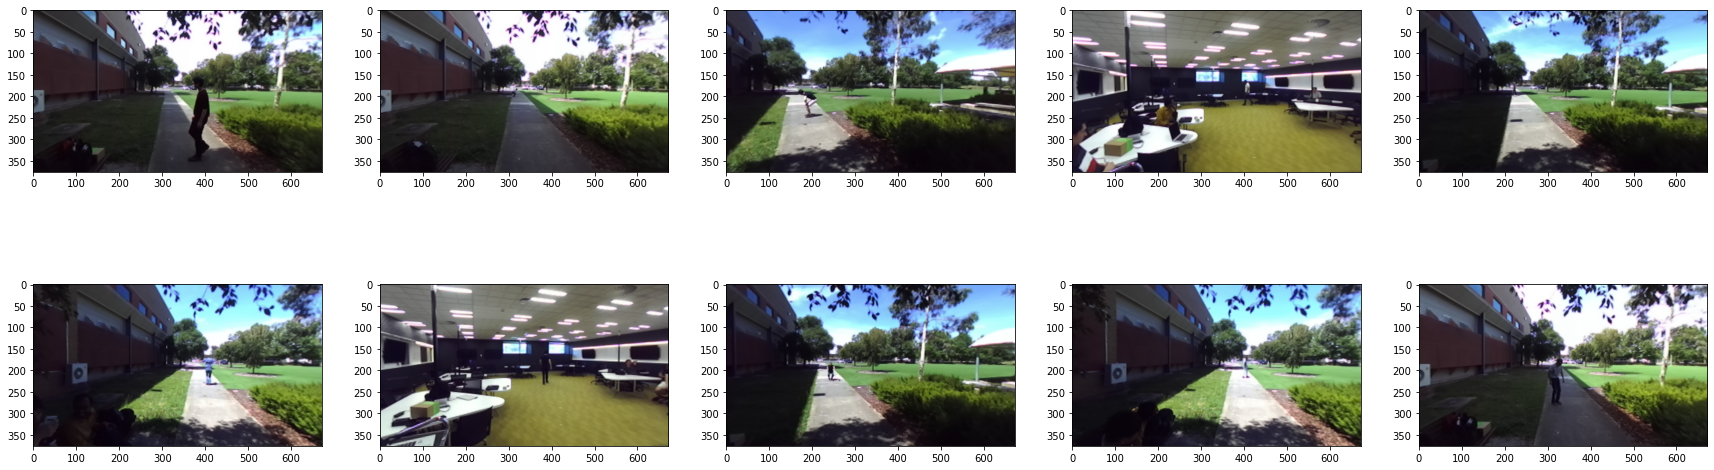

In [35]:
train_gen, val_gen, test_gen = get_imagery_data_sets(train_set, val_set, test_set, "./", 'file_path', ["xmin", "ymin", "xmax", "ymax"], 5, (376, 672))

plt.figure(figsize=[30, 100])

count = 0
for i in range(0, 2):
  x,y = train_gen.__getitem__(i)
  img_in_batch = x.shape[0]
  for index in range(0, img_in_batch):
    img = x[index]
    plt.subplot(20, 5, count + 1)

    count += 1

    plt.imshow(img)


# Train Person Detection

In [64]:
INIT_LR = 0.001
NUM_EPOCHS = 25
BATCH_SIZE = 32
INPUT_SIZE = (376, 672)
METRICS_CI = [
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc',curve='ROC',),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

train_gen, val_gen, test_gen = get_imagery_data_sets(train_set, val_set, test_set, "./", 'file_path', ["xmin", "ymin", "xmax", "ymax"], BATCH_SIZE, INPUT_SIZE)

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  INIT_LR,
  decay_steps=train_gen.__len__() * 1000,
  decay_rate=10,
  staircase=False)

# Hyperparameters.
parameters = {
    # Compile parameters.
    "optimizer": tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    "loss": tf.keras.losses.MeanSquaredError(),
    "metrics": METRICS_CI,

    # Generator Parameters.
    "batch_size": BATCH_SIZE,

    # Fit perameters.
    "epochs": NUM_EPOCHS
}

# reg_lambda = 0.001

Found 9947 validated image filenames.
Found 1243 validated image filenames.
Found 1244 validated image filenames.


In [25]:


# Model
IMG_SHAPE = (None,None, 3)
inputs = keras.Input(shape=IMG_SHAPE)
base_model = tf.keras.applications.InceptionV3(input_tensor=inputs, 
                                               include_top=False, 
                                               weights='imagenet')

for layer in base_model.layers:
  layer.trainable = False

# flatten the max-pooling output of InceptionV3
x = base_model.output
x = Flatten()(x)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(x)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)

# 4 Neurons for the 4 bounding box coordinates.
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

# construct the model we will fine-tune for bounding box regression
model = Model(inputs=base_model.input, outputs=bboxHead)
model.summary()
model_name = "test"

Found 9947 validated image filenames.
Found 1243 validated image filenames.
Found 1244 validated image filenames.
87924736/87910968 [==============================] - 1s 0us/step


ValueError: ignored

In [ ]:
# history, model = run_model(model, parameters, model_name, train_generator, val_generator)

## Helper functions for running and evaluation YOLO v3 model output.

In [55]:
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    weights = norm_layer.set_weights([gamma, beta, mean, var])  

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def preprocess_input(image, net_h, net_w):
    new_h, new_w, _ = image.shape

    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)/new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)/new_h
        new_h = net_h

    # resize the image to the new size
    resized = cv2.resize(image[:,:,::-1]/255., (int(new_w), int(new_h)))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[int((net_h-new_h)//2):int((net_h+new_h)//2), int((net_w-new_w)//2):int((net_w+new_w)//2), :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image

def decode_netout(netout, anchors, obj_thresh, nms_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5

    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            #objectness = netout[..., :4]
            
            if(objectness.all() <= obj_thresh): continue
            
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]

            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height  
            
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

            boxes.append(box)

    return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
        
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0
                    
def draw_boxes(image, boxes, labels, obj_thresh):
    for box in boxes:
        label_str = ''
        label = -1
        
        for i in range(len(labels)):
            if box.classes[i] > obj_thresh:
                label_str += labels[i]
                label = i
                print(labels[i] + ': ' + str(box.classes[i]*100) + '%')
                
        if label >= 0:
            cv2.rectangle(image, (box.xmin,box.ymin), (box.xmax,box.ymax), (0,255,0), 3)
            cv2.putText(image, 
                        label_str + ' ' + str(box.get_score()), 
                        (box.xmin, box.ymin - 13), 
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        1e-3 * image.shape[0], 
                        (0,255,0), 2)
        
    return image 

## Create YOLO V3 Model

In [58]:
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model

[YOLOv3 Architecture](https://miro.medium.com/max/1200/1*d4Eg17IVJ0L41e7CTWLLSg.png)

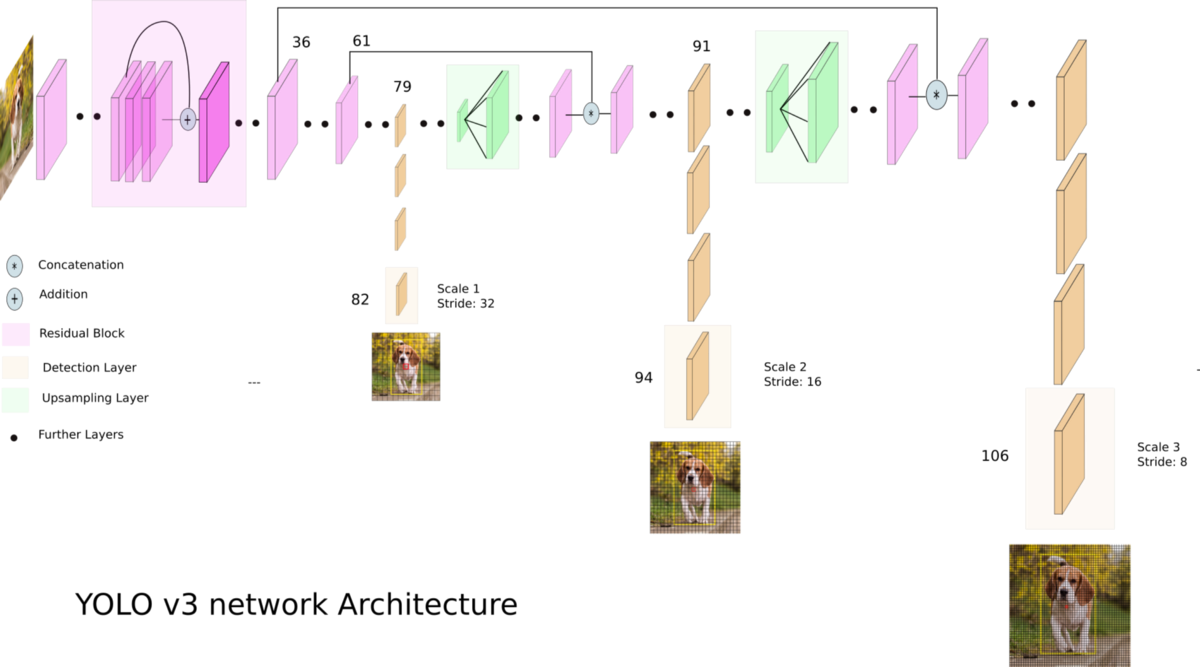

# Raw Person Detection Performance

In [59]:
# Make the yolov3 model to predict 80 classes on COCO.
yolov3 = make_yolov3_model()

In [60]:
weights_path = "/content/drive/MyDrive/DL/yolov3.weights"

# Load the weights trained on COCO into the model.
weight_reader = WeightReader(weights_path)
weight_reader.load_weights(yolov3)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [74]:
train_gen, val_gen, test_gen = get_imagery_data_sets(train_set, val_set, test_set, "./", 'file_path', ["xmin", "ymin", "xmax", "ymax"], 1, INPUT_SIZE)

x,y = train_gen.__getitem__(0)
x.shape

Found 9947 validated image filenames.
Found 1243 validated image filenames.
Found 1244 validated image filenames.


(1, 376, 672, 4)

In [75]:
x.shape[1]

376

In [82]:

# set some parameters
net_h = 500
net_w = 500

obj_thresh, nms_thresh = 0.5, 0.45
anchors = [[116,90,  156,198,  373,326],  [30,61, 62,45,  59,119], [10,13,  16,30,  33,23]]
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", 
          "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", 
          "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", 
          "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", 
          "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", 
          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", 
          "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", 
          "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", 
          "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", 
          "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

# preprocess the image.
image_path = "./Images/01_INSIDE_00044.png"
# image = cv2.imread(image_path)
# image_h, image_w, _ = image.shape
# new_image = preprocess_input(image, net_h, net_w)

# train_gen.__getitem__(0)

# print(new_image.shape)

def loadImage(image_path):
  img = tf.keras.preprocessing.image.load_img(image_path)
  img = tf.keras.preprocessing.image.img_to_array(img, dtype = 'float32')
  
  return img/255

img = loadImage(image_path)

pixels = np.expand_dims(img, axis=0)
print(pixels.shape)

# run the prediction
yolos = yolov3.predict(pixels)
boxes = []

for i in range(len(yolos)):
    # decode the output of the network.
    boxes += decode_netout(yolos[i][0], anchors[i], obj_thresh, nms_thresh, net_h, net_w)

# correct the sizes of the bounding boxes
correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)

# suppress non-maximal boxes
do_nms(boxes, nms_thresh)     

# draw bounding boxes on the image using labels
draw_boxes(image, boxes, labels, obj_thresh) 

# write the image with bounding boxes to file
cv2.imwrite(image_path[:-4] + '_detected' + image_path[-4:], (image).astype('uint8')) 

(1, 376, 672, 3)


ValueError: ignored

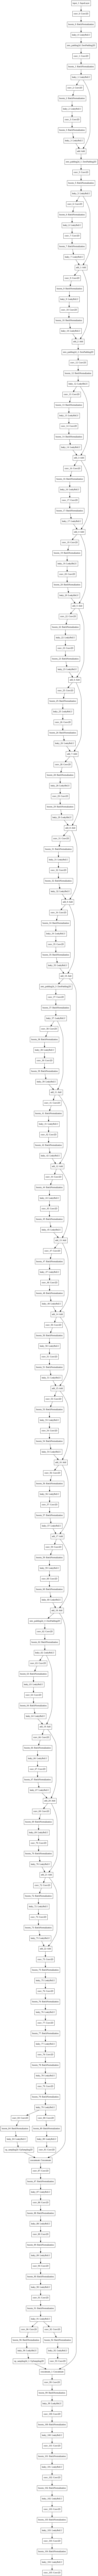

In [ ]:
keras.utils.plot_model(model, "yolov3.png")